# Camera Calibration

In this assignment we are going to perform the calibration of the camera.

The following code downloads 13 images that we are going to use for camera calibration.

In [ ]:
from matplotlib import pyplot as plt
import requests
import io
import PIL
import numpy as np

In [ ]:
images = []

for i in range(1, 15):
  if i == 10:
    continue
  image = requests.get('https://github.com/opencv/opencv/raw/master/samples/data/left{:02d}.jpg'.format(i))
  images.append(np.array(PIL.Image.open(io.BytesIO(image.content))))

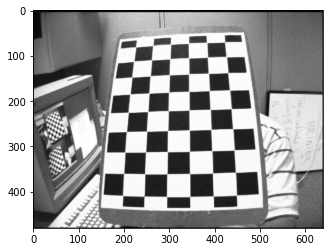

In [ ]:
plt.imshow(images[10], 'Greys_r')

## Distortion

You can see that image contains distrotion. Parallel lines of the chessboard pattern are not parallel in the image. So here we are going to take into account distortion as well.

## Scale
You remember that in calibration procedure we set world coordinate system to the corner of the chessboard pattern. But how do we know the distance between corners in the real world? Unfortunately we don't know, because we didn't take this pictures, but we can assume that size of the one square is 1x1 and solve calibration problem in terms of square size.

## Chessboard detection

To detect the corners of the chessboard you can use OpenCV. Here is the example:

In [ ]:
import cv2

corners = cv2.findChessboardCorners(
    images[10],
    (7, 6), # size of the chessboard patter
  )

Now let's visualize the result of the pattern detection.

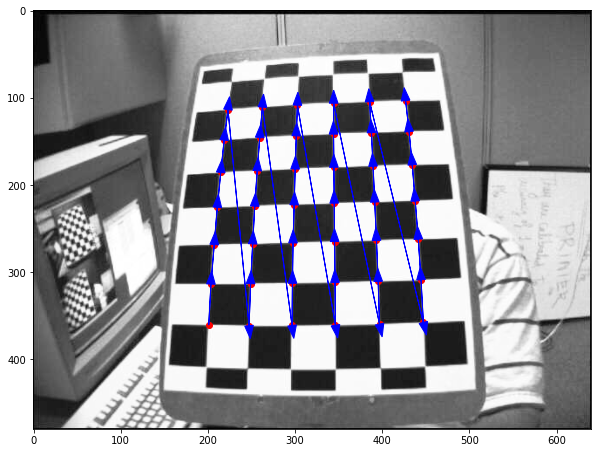

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images[10], 'Greys_r')
plt.scatter(corners[1][:, 0, 0], corners[1][:, 0, 1], c='r')
for i in range(41):
  plt.arrow(
      corners[1][i, 0][0],
      corners[1][i, 0][1],
      corners[1][i + 1, 0][0] - corners[1][i, 0][0],
      corners[1][i + 1, 0][1] - corners[1][i, 0][1], color='blue', head_width=10)

As we discussed above, you can define your own coordinate system over the calibration board and constuct correspondencies between points.
For example: left bottom corner can have coordinates (0, 0), next corner along x-axis is (1, 0) and so on.

Now, giving correspondencies we would like to estimate the homography. How can we do it?

Let's say we have point $(x, y)$ on the calibration board and $(x', y')$ in the image plane. Then we get

$$
\begin{pmatrix}
wx' \\
wy' \\
w
\end{pmatrix} =
H \begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
$$

We don't know $w$, but we know that $(x', y', 1)$ and $(wx', wy', w)$ are collinear. Therefore, their cross-product is equal 0.

$$
\begin{pmatrix}
x' \\
y' \\
1
\end{pmatrix}
\times H \begin{pmatrix}
x \\
y \\
1
\end{pmatrix} = 0
$$

Let
$$
H = \begin{bmatrix}
h_1^T \\
h_2^T \\
h_3
\end{bmatrix}
$$

$$
\mathbf{x} = \begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
$$
where $h_i$ is the i-th row. Then cross-product is going to look as follows:

$$
\begin{pmatrix}
x' \\
y' \\
1
\end{pmatrix}
\times
\begin{pmatrix}
h_1^T\mathbf{x} \\
h_2^T\mathbf{x} \\
h_3^T\mathbf{x}
\end{pmatrix} = 0
$$

Now, by reodering, you should construct the equations that is going to look as follows:

$$
A\mathbf{h} = 0
$$
where
$$
\mathbf{h} =
\begin{bmatrix}
h_1 \\
h_2 \\
h_3
\end{bmatrix}_{9\times1}
$$

You remember that solution is noisy, therefore we would like to find vector that minimizes norm of the $A\mathbf{x}$. Luckily this vector is eigenvector with the smallest eigenvalue. So you can use `np.linalg.eig` to find it.

Implement function `estimate_homography`. Then find homographies for each image.


In [ ]:

def estimate_homography(src_points, dst_points):
  A = []
  for i, src_point in enumerate(src_points):
    dst_point = dst_points[i]
    A.append(
        [-src_point[0], -src_point[1], -1, 0, 0, 0, src_point[0] * dst_point[0], src_point[1] * dst_point[0], dst_point[0]]
    )
    A.append(
        [0, 0, 0, -src_point[0], -src_point[1], -1, src_point[0] * dst_point[1], dst_point[1] * src_point[1], dst_point[1]]
    )
  A = np.stack(A, axis=0)
  u, s, v = np.linalg.svd(A)

  h = np.reshape(v[-1], (3, 3))
  h = (1/h.item(8)) * h
  return h

In [ ]:

def estimate_homography(src_points, dst_points):
  A = []
  for i, src_point in enumerate(src_points):
    dst_point = dst_points[i]
    A.append(
        [-src_point[0], -src_point[1], -1, 0, 0, 0, src_point[0] * dst_point[0], src_point[1] * dst_point[0], dst_point[0]]
    )
    A.append(
        [0, 0, 0, -src_point[0], -src_point[1], -1, src_point[0] * dst_point[1], dst_point[1] * src_point[1], dst_point[1]]
    )
  A = np.stack(A, axis=0)
  u, s, v = np.linalg.svd(A)

  h = np.reshape(v[-1], (3, 3))
  h = (1/h.item(8)) * h
  return h


homographies = []

for image in images:
  ok, corners = cv2.findChessboardCorners(
    image,
    (7, 6), # size of the chessboard patter
  )
  if not ok:
    continue
  corners = corners[:, 0]
  calibration_points = np.meshgrid(np.arange(0, 7), np.arange(0, 6))
  calibration_points = np.stack(calibration_points, axis=-1).reshape(-1, 2)
  homographies.append(estimate_homography(calibration_points, corners))

In [ ]:
homographies = []

for image in images:
  ok, corners = cv2.findChessboardCorners(
    image,
    (7, 6), # size of the chessboard patter
  )
  if not ok:
    continue
  corners = corners[:, 0]
  calibration_points = np.meshgrid(np.arange(0, 7), np.arange(0, 6))
  calibration_points = np.stack(calibration_points, axis=-1).reshape(-1, 2)
  homographies.append(estimate_homography(calibration_points, corners))

After estimating the homographies, you can now estimate matrix $B$ that we discussed in the lecture about camera calibration. Here, we again need to construct system of linear equations and find the smallest eigenvector.

Look at the equations (8) and (9) at this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf) to construct correct system and find $B$.

In [ ]:
# Estimate B using homographies

def v_vector(column_1, column_2):
  return np.array([
     column_1[0] * column_2[0],
    column_1[0] * column_2[1] + column_1[1] * column_2[0],
    column_1[1] * column_2[1],
    column_1[2] * column_2[0] + column_1[0] * column_2[2],
    column_1[2] * column_2[1] + column_1[1] * column_2[2],
    column_1[2] * column_2[2],
  ])


A = []
for homography in homographies:
  A.append(v_vector(homography[:, 0], homography[:, 1]))
  A.append(v_vector(homography[:, 0], homography[:, 0]) - v_vector(homography[:, 1], homography[:, 1]))

A = np.stack(A, axis=0)
v = np.linalg.eig(A.T.dot(A))[-1][:, -1]

B = np.array(
    [
        [v[0], v[1], v[3]],
        [v[1], v[2], v[4]],
        [v[3], v[4], v[5]],
    ]
)

After estimating $B$ you can construct calibration matrix. The insturction on consturction of the calibration matrix can be found in the appendix B of Zhang's [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf).

In [ ]:
# Estimate intrinsics

v_0 = (B[0, 1] * B[0, 2] - B[0, 0] * B[1, 2]) / (B[0, 0] * B[1, 1] - B[0, 1] ** 2)
lamb = B[2, 2] - (B[0, 2] ** 2 + v_0 * (B[0, 1] * B[0, 2] - B[0, 0] * B[1, 2])) / B[0, 0]
alpha = np.sqrt(lamb / B[0, 0]) # focal distance

In [ ]:
alpha

534.4184187107533

Intrinsics should be approximately equal to
$$
\begin{pmatrix}
536 &  0   & 341 \\
0 & 536 & 232 \\
0 & 0 & 1
\end{pmatrix}
$$
You can obtain result that can differ up to 10, because we didn't take into account distortion.

The same that you implemented can be done with the OpenCV library.
Homography estimation can be obtained with `cv2.findHomograpgy` function and complete camera calibration can be obtained with the `cv2.calibrateCamera`. Run this functions and compare your results and opencv results.

In [ ]:
# Calibrate camera with the OpenCV

import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for image in images:
    gray = image
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

Finally, after calibration, we can undistort our images to make parallel lines parallel in the image plane.
Call `cv2.undistort` with the obtained calibration parameters to remove distortion from the image.

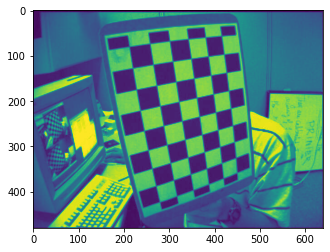

In [ ]:
# Remove distortion from the image and compare images
dst = cv2.undistort(image, mtx, dist, None, mtx)

plt.imshow(image)

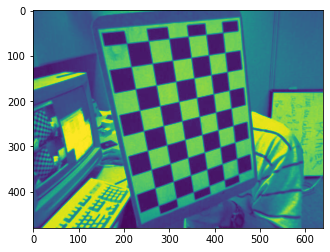

In [ ]:
plt.imshow(dst)

After removing distrortion we can do some fancy stuff with our images. For example, we can insert some virtual objects in the image, this actually how augmented reality algorithms work.

Implement the following algorithm:

1. Detect corners over image without distortion
2. Find extrinsic parameters for this image with function `cv2.solvePnP`. You should pass points in 3D (remember that all points in the calibration board have z coordinate equal to 0), corresponding pixel points and intrinsic parameters. The function returns rotation and translation: extrinsic cameras for a given frame.
3. Choose points to draw . We suggest to simply draw axis over calibration board. For example: line connecting points (0, 0) and (0, 2).
4. Project new 3D points to image with the function `cv2.projectPoints`.
5. Draw figures in the image plane.

In [ ]:
# Draw new objects over calibration board

In [ ]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)


ret, corners = cv2.findChessboardCorners(dst, (7,6),None)
corners2 = cv2.cornerSubPix(dst, corners,(11,11),(-1,-1),criteria)
# Find the rotation and translation vectors.
ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
# project 3D points to image plane
imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
dst = draw(dst,corners2,imgpts)

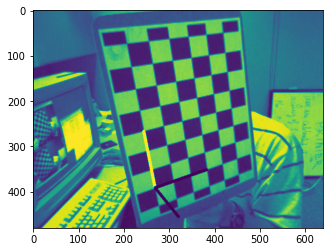

In [ ]:
plt.imshow(dst)